## Width vs Depth [Part 1].ipynb

In [18]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os

import pickle
import copy
import os

In [19]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

def get_relu_joint(weight_1, weight_2, bias, extent=1):
    if np.abs(weight_2) < 1e-8: 
        x_intercept = -bias / weight_1
        return [[x_intercept, -extent], [x_intercept, extent]] if -extent <= x_intercept <= extent else []
    elif np.abs(weight_1) < 1e-8:
        y_intercept = -bias / weight_2
        return [[-extent, y_intercept], [extent, y_intercept]] if -extent <= y_intercept <= extent else []
    else:
        points = []
        for x in [-extent, extent]:
            y = (-x * weight_1 - bias) / weight_2
            if -extent <= y <= extent: points.append([x, y])
        for y in [-extent, extent]:
            x = (-y * weight_2 - bias) / weight_1
            if -extent <= x <= extent: points.append([x, y])
        unique_points = []
        for p in points:
            is_duplicate = False
            for existing in unique_points:
                if abs(p[0] - existing[0]) < 1e-8 and abs(p[1] - existing[1]) < 1e-8:
                    is_duplicate = True
                    break
            if not is_duplicate:
                unique_points.append(p)
        return unique_points

def viz_map_with_predictions(ax, map, X, y):
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    
    X_denorm=denorm(X[:1000,:])
    # plt.scatter(X_denorm[:,0], X_denorm[:,1], c=y[:1000], s=2, alpha=0.8)
    labels=y[:1000]
    y_hat=torch.argmax(model(torch.tensor(X[:1000,:]).float()).detach(),1).numpy()
    tp_mask=np.logical_and(labels==1, y_hat==1)
    fp_mask=np.logical_and(labels==0, y_hat==1)
    fn_mask=np.logical_and(labels==1, y_hat==0)
    tn_mask=np.logical_and(labels==0, y_hat==0)
    ax.scatter(X_denorm[tp_mask,0], X_denorm[tp_mask,1], c='g', s=3, alpha=0.8)
    ax.scatter(X_denorm[fp_mask,0], X_denorm[fp_mask,1], c='r', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[fn_mask,0], X_denorm[fn_mask,1], c='orange', marker='x', s=5, alpha=0.8)
    ax.scatter(X_denorm[tn_mask,0], X_denorm[tn_mask,1], c='purple', marker='o', s=5, alpha=0.8)

def save_viz(model, save_path=None):
    plt.clf()
    probe=np.zeros((100,100,2))
    for j, xx in enumerate(np.linspace(-1, 1, 100)):
        for k, yy in enumerate(np.linspace(-1, 1, 100)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(100**2, -1)
    
    fig=plt.figure(0,(10,10)); 
    ax=fig.add_subplot(111)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmin(probe_logits, 2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    # ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
    #            extent=[0, 960, 960, 0],  # This maps to image coordinates
    #            alpha=0.7,
    #            cmap='viridis')
    if save_path is not None: plt.savefig(save_path)

In [20]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en.svg.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<10
belgium_region=((map-belgium_color)**2).sum(-1)<10000

num_points_to_sample=10000 #10000

b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
belgium_coords=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

rI=np.arange(len(y))
np.random.shuffle(rI)
X=X[rI,:]
y=y[rI]

In [21]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [22]:
accuracies=[]
for random_seed in range(20):
    torch.manual_seed(random_seed)
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Initialize model and optimizer
    model = BaarleNet([2,2])
    
    #Larger weight init
    bound=2.5
    with torch.no_grad():
        model.model[0].weight.uniform_(-bound, bound)
        model.model[0].bias.uniform_(-bound, bound)  
        model.model[2].weight.uniform_(-bound, bound)
        model.model[2].bias.uniform_(-bound, bound)  
        if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
            model.model[4].weight.uniform_(-bound, bound)
            model.model[4].bias.uniform_(-bound, bound) 

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.25)
    optimizer = optim.Adam(model.parameters(), lr=0.0025) #0.005
    
    num_epochs = 12000
    for epoch in range(num_epochs):
        # Batch
        # outputs = model(X_tensor)
        # loss = criterion(outputs, y_tensor)
    
        #Stochastic
        outputs = model(torch.tensor(X[epoch%len(y)]).float())
        loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        
    outputs_batch = model(X_tensor)
    accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
    print(f'Random Seed [{random_seed}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    accuracies.append(accuracy)

Random Seed [0], Loss: 0.6739, Accuracy: 0.5514
Random Seed [1], Loss: 0.5121, Accuracy: 0.6889
Random Seed [2], Loss: 0.1957, Accuracy: 0.7606
Random Seed [3], Loss: 0.7210, Accuracy: 0.5000
Random Seed [4], Loss: 0.2955, Accuracy: 0.7789
Random Seed [5], Loss: 0.1155, Accuracy: 0.7596
Random Seed [6], Loss: 0.2681, Accuracy: 0.7401
Random Seed [7], Loss: 0.1733, Accuracy: 0.7923
Random Seed [8], Loss: 0.4213, Accuracy: 0.6577
Random Seed [9], Loss: 0.3643, Accuracy: 0.7279
Random Seed [10], Loss: 0.6718, Accuracy: 0.5362
Random Seed [11], Loss: 0.2835, Accuracy: 0.7266
Random Seed [12], Loss: 0.5616, Accuracy: 0.6841
Random Seed [13], Loss: 0.2610, Accuracy: 0.7586
Random Seed [14], Loss: 0.3396, Accuracy: 0.7913
Random Seed [15], Loss: 0.2666, Accuracy: 0.7575
Random Seed [16], Loss: 0.1730, Accuracy: 0.7654
Random Seed [17], Loss: 0.5591, Accuracy: 0.6303
Random Seed [18], Loss: 0.4372, Accuracy: 0.7632
Random Seed [19], Loss: 0.5860, Accuracy: 0.6349


- Ok wow 2x2 model seems kind a lottery ticket-y
- So the narrative angle then might be comparing like a 32 or 64 neuron shallow model to distributing those neurons?
- I think I can collapse down to somethign small to make points as I need to?
- Yeah so it takes a long time to find a lottery ticket, and the decision boundary is not that cool once you do.
- Yeah what's like the minimum interesting depth example?
- Like "oh my god, if you take these N neurons from a single layer and spread them accross J layers you can do whatever the fuck you want." 

In [8]:
random_seed=315
torch.manual_seed(random_seed)  

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Initialize model and optimizer
model = BaarleNet([2,2])
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.25)
optimizer = optim.Adam(model.parameters(), lr=0.0025) #0.005

num_epochs = 400
for epoch in range(num_epochs):
    # Batch
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    #Stochastic
    # outputs = model(torch.tensor(X[epoch%len(y)]).float())
    # loss = criterion(outputs, torch.tensor(y[epoch%len(y)])) 

    #Worth trying minibatch?
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()

    # if epoch==307: break #Stop early here so weights don't get updated before we poke around
    
    optimizer.step()
    if (epoch+1) % (num_epochs//10) == 0:
        outputs_batch = model(X_tensor)
        accuracy=(torch.argmax(outputs_batch, dim=1)==y_tensor).sum().item()/len(y)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


Epoch [800/8000], Loss: 0.3823, Accuracy: 0.8497
Epoch [1600/8000], Loss: 0.3778, Accuracy: 0.8507
Epoch [2400/8000], Loss: 0.3777, Accuracy: 0.8508
Epoch [3200/8000], Loss: 0.3777, Accuracy: 0.8508
Epoch [4000/8000], Loss: 0.3777, Accuracy: 0.8508
Epoch [4800/8000], Loss: 0.3777, Accuracy: 0.8510
Epoch [5600/8000], Loss: 0.3777, Accuracy: 0.8508
Epoch [6400/8000], Loss: 0.3777, Accuracy: 0.8509
Epoch [7200/8000], Loss: 0.3777, Accuracy: 0.8509
Epoch [8000/8000], Loss: 0.3777, Accuracy: 0.8510


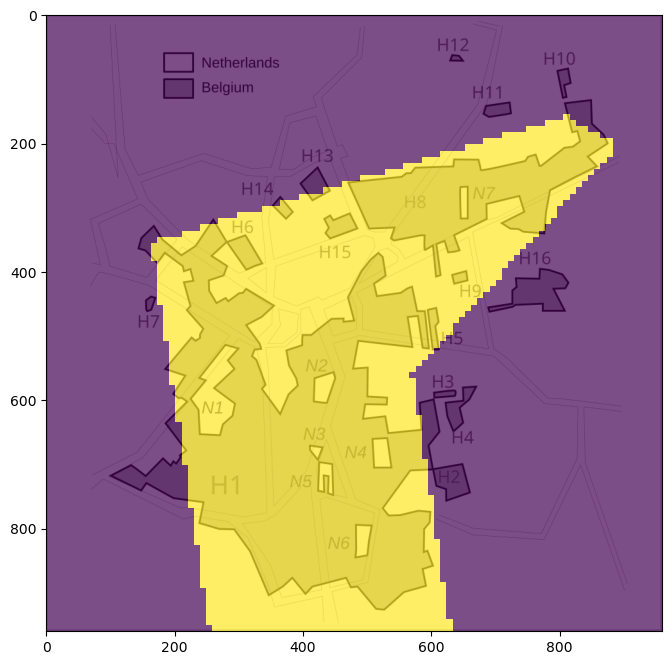

In [9]:
fig=plt.figure(0,(8,8))
ax=fig.add_subplot(111)

probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')

Saving results to: /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/depth_experiments_1
Parameter containing:
tensor([[-1.6949, -1.0887],
        [ 0.9080,  2.0760]], requires_grad=True)

=== Training with seed 0 ===
initial loss =  0.7421525120735168
Epoch [250/2500], Loss: 0.6037, Accuracy: 0.6646
Epoch [500/2500], Loss: 0.4650, Accuracy: 0.7991
Epoch [750/2500], Loss: 0.4583, Accuracy: 0.8010
Epoch [1000/2500], Loss: 0.4574, Accuracy: 0.8085
Epoch [1250/2500], Loss: 0.4568, Accuracy: 0.8106
Epoch [1500/2500], Loss: 0.4568, Accuracy: 0.8088
Epoch [1750/2500], Loss: 0.4568, Accuracy: 0.8096
Epoch [2000/2500], Loss: 0.4568, Accuracy: 0.8095
Epoch [2250/2500], Loss: 0.4568, Accuracy: 0.8089
Epoch [2500/2500], Loss: 0.4568, Accuracy: 0.8091
*** NEW BEST MODEL: Seed 0, Accuracy 0.8091 ***
*** NEW WORST MODEL: Seed 0, Accuracy 0.8091 ***
Saved training data to /Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/depth_experiments_1/training_data_seed_00_acc_0.

<Figure size 640x480 with 0 Axes>

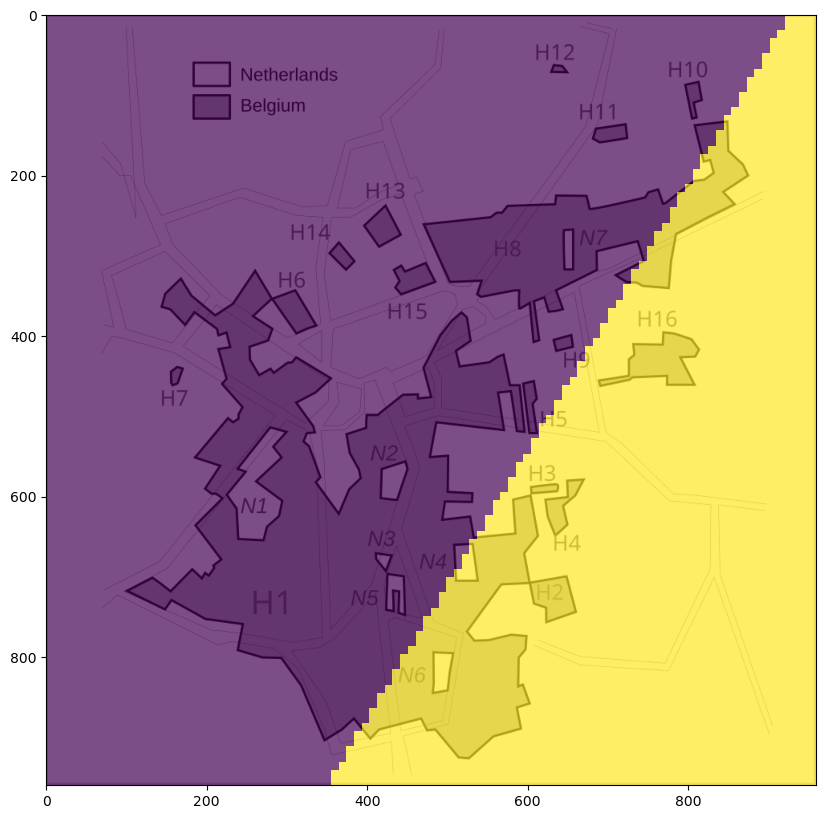

In [5]:
# X_tensor = torch.FloatTensor(X)
# y_tensor = torch.tensor(y)

# # Training parameters
# num_epochs = 2500 #Trying shorter to reduce arbitrary weight scaling
# num_seeds = 16 #8 is nice for quick tests

# # Configure output directory
# output_dir = "/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/depth_experiments_1"  # Change this to your desired directory
# os.makedirs(output_dir, exist_ok=True)
# print(f"Saving results to: {output_dir}")

# # Track best and worst models
# best_model_data = {'accuracy': -1, 'seed': None, 'initial_params': None, 'final_params': None}
# worst_model_data = {'accuracy': float('inf'), 'seed': None, 'initial_params': None, 'final_params': None}
# all_training_data=[]

# for seed_idx in range(num_seeds):
#     random_seed = seed_idx  # You can change this to any seed generation logic
#     torch.manual_seed(random_seed)
    
#     # Initialize model and optimizer
#     model = BaarleNet([2,2])
#     #Mess with initialization
#     bound=2.5
#     with torch.no_grad():
#         model.model[0].weight.uniform_(-bound, bound)
#         model.model[0].bias.uniform_(-bound, bound)  
#         model.model[2].weight.uniform_(-bound, bound)
#         model.model[2].bias.uniform_(-bound, bound)  
#         if len(model.model)>3: #ONLY SETUP FOR 2 hidden layers so far!
#             model.model[4].weight.uniform_(-bound, bound)
#             model.model[4].bias.uniform_(-bound, bound) 

#     print(model.model[0].weight)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.01)
    
#     # Store initial parameters (deep copy)
#     initial_params = {}
#     for name, param in model.named_parameters():
#         initial_params[name] = param.data.clone()
    
#     # Data storage for this run
#     training_data = {
#         'seed': random_seed,
#         'weights_history': [],
#         'gradients_history': [],
#         'xy_history': [],
#         'loss_history': [],
#         'accuracy_history': [],
#         'initial_params': initial_params  # Store initial params in training data too
#     }

#     print(f"\n=== Training with seed {random_seed} ===")

#     for epoch in range(num_epochs):
#         # Get current data point
#         current_idx = epoch % len(y)
#         # Stochastic
#         # current_x = torch.tensor(X[current_idx]).float()
#         # current_y = torch.tensor(y[current_idx])

#         #Try batch for a second
#         current_x = torch.tensor(X).float()
#         current_y = torch.tensor(y)  
        
#         # Forward pass
#         outputs = model(current_x)
#         loss = criterion(outputs, current_y)
#         if epoch==0:
#             print('initial loss = ', loss.item())
        
#         # Store current X,y values
#         training_data['xy_history'].append({
#             'epoch': epoch,
#             'x': X[current_idx].copy(),
#             'y': y[current_idx]
#         })
        
#         # Zero gradients
#         optimizer.zero_grad()
        
#         # Backward pass
#         loss.backward()
        
#         # Store model weights (deep copy to avoid reference issues)
#         current_weights = {}
#         for name, param in model.named_parameters():
#             current_weights[name] = param.data.clone()
#         training_data['weights_history'].append(current_weights)
        
#         # Store model gradients (deep copy)
#         current_gradients = {}
#         for name, param in model.named_parameters():
#             if param.grad is not None:
#                 current_gradients[name] = param.grad.clone()
#             else:
#                 current_gradients[name] = None
#         training_data['gradients_history'].append(current_gradients)
        
#         # Update parameters
#         optimizer.step()
        
#         # Store loss
#         training_data['loss_history'].append(loss.item())
        
#         # Calculate and store accuracy periodically
#         if (epoch + 1) % (num_epochs // 10) == 0:
#             with torch.no_grad():
#                 outputs_batch = model(X_tensor)
#                 accuracy = (torch.argmax(outputs_batch, dim=1) == y_tensor).sum().item() / len(y)
#                 training_data['accuracy_history'].append({
#                     'epoch': epoch,
#                     'accuracy': accuracy
#                 })
#                 print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
    
#     # Calculate final accuracy
#     with torch.no_grad():
#         final_outputs = model(X_tensor)
#         final_accuracy = (torch.argmax(final_outputs, dim=1) == y_tensor).sum().item() / len(y)
    
#     # Store final parameters (deep copy)
#     final_params = {}
#     for name, param in model.named_parameters():
#         final_params[name] = param.data.clone()
    
#     # Check if this is the best or worst model so far
#     if final_accuracy > best_model_data['accuracy']:
#         best_model_data = {
#             'accuracy': final_accuracy,
#             'seed': random_seed,
#             'initial_params': {name: param.clone() for name, param in initial_params.items()},
#             'final_params': {name: param.clone() for name, param in final_params.items()}
#         }
#         print(f"*** NEW BEST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
#     if final_accuracy < worst_model_data['accuracy']:
#         worst_model_data = {
#             'accuracy': final_accuracy,
#             'seed': random_seed,
#             'initial_params': {name: param.clone() for name, param in initial_params.items()},
#             'final_params': {name: param.clone() for name, param in final_params.items()}
#         }
#         print(f"*** NEW WORST MODEL: Seed {random_seed}, Accuracy {final_accuracy:.4f} ***")
    
#     # Save data as pickle file
#     filename = os.path.join(output_dir, f"training_data_seed_{random_seed:02d}_acc_{final_accuracy:.4f}.pkl")
    
#     # Add final accuracy and params to the data
#     training_data['final_accuracy'] = final_accuracy
#     training_data['final_model_state'] = model.state_dict()
#     training_data['final_params'] = final_params
    
#     with open(filename, 'wb') as f:
#         pickle.dump(training_data, f)
    
#     print(f"Saved training data to {filename}")
#     print(f"Final accuracy: {final_accuracy:.4f}")

#     # Restore initial weights for visualization
#     with torch.no_grad():
#         for name, param in model.named_parameters():
#             param.data = training_data['weights_history'][0][name]

#     print(model.model[0].weight)
#     viz_fn = os.path.join(output_dir, f"{final_accuracy:.4f}_random_init.png")
#     save_viz(model, str(viz_fn))

#     all_training_data.append(training_data)

# # After all training is complete, save best and worst model data
# best_worst_data = {
#     'best_model': best_model_data,
#     'worst_model': worst_model_data
# }

# best_worst_filename = os.path.join(output_dir, "best_worst_models.pkl")
# with open(best_worst_filename, 'wb') as f:
#     pickle.dump(best_worst_data, f)

# print(f"\n=== FINAL RESULTS ===")
# print(f"Best model: Seed {best_model_data['seed']}, Accuracy {best_model_data['accuracy']:.4f}")
# print(f"Worst model: Seed {worst_model_data['seed']}, Accuracy {worst_model_data['accuracy']:.4f}")
# print(f"Best/worst model data saved to: {best_worst_filename}")

<Figure size 640x480 with 0 Axes>

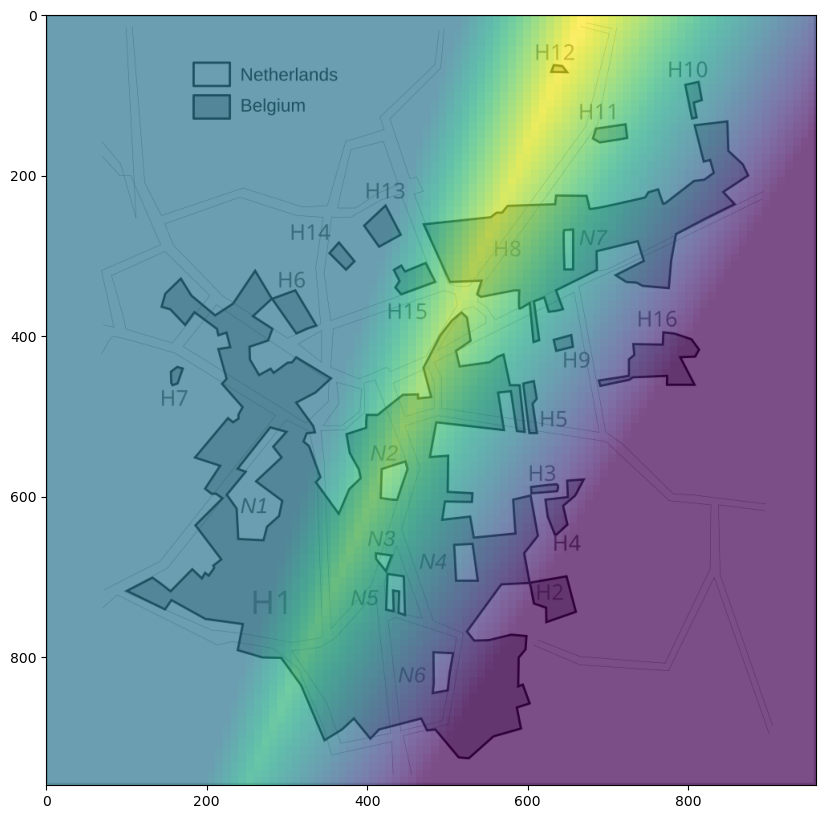

In [14]:
plt.clf()
probe=np.zeros((100,100,2))
for j, xx in enumerate(np.linspace(-1, 1, 100)):
    for k, yy in enumerate(np.linspace(-1, 1, 100)):
        probe[j, k]=[yy,xx]
probe=probe.reshape(100**2, -1)

fig=plt.figure(0,(10,10)); 
ax=fig.add_subplot(111)
probe_logits=model(torch.tensor(probe).float())
probe_logits=probe_logits.detach().numpy().reshape(100,100,2)
probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))

ax.imshow(map.mean(2), cmap='gray')
# ax.imshow(np.flipud(np.argmin(probe_logits, 2)), 
#            extent=[0, 960, 960, 0],  # This maps to image coordinates
#            alpha=0.7,
#            cmap='viridis')
ax.imshow(np.flipud(probe_softmax[:,1].reshape(100, 100)), 
           extent=[0, 960, 960, 0],  # This maps to image coordinates
           alpha=0.7,
           cmap='viridis')
# # if save_path is not None: plt.savefig(save_path)

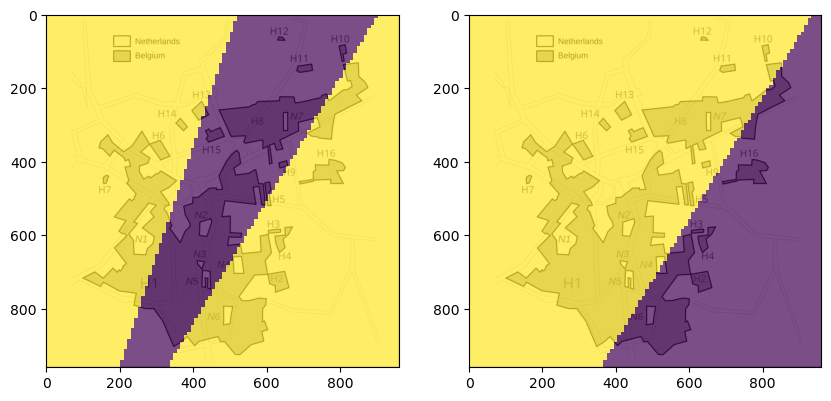

In [13]:
fig=plt.figure(0,(10,5)); 
for i in range(2):
    ax=fig.add_subplot(1,2,i+1)
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(probe_logits[:,:,i]>0), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

In [7]:
np.unique(np.argmax(probe_logits, 2))

array([0, 1])

In [8]:
np.argmax(probe_logits, 2)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])